# Evoked Potential Signal Processing with DSP (500 Hz Annotated Version)

This notebook demonstrates how to apply Digital Signal Processing (DSP) techniques to real EEG data recorded at 500 Hz. The goal is to isolate visual evoked potentials (VEPs) using a sequence of signal processing steps:

1. Load and visualize raw EEG data
2. Apply a bandpass filter (1–30 Hz)
3. Epoch the data assuming stimuli every 2 seconds
4. Average the epochs to enhance signal-to-noise ratio
5. Use the Fast Fourier Transform (FFT) to analyze frequency components

> Note: We simulate regular stimulus timing; actual stimulus markers were not included in the public dataset.
> Oroginal datasets sourced from: https://www.nature.com/articles/sdata201447

In [1]:
# Step 1: Load EEG Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import fft, fftfreq

# Load the data
#file_path = 'Arithmetic_sub_1.csv'
file_path = r"C:\Users\nssew\Downloads\fattyliverUS_data\DSP_Blog\Arithmetic_sub_1.csv\Arithmetic_sub_1.csv"#'Arithmetic_sub_1.csv'#
df = pd.read_csv(file_path)

# Drop unnamed index column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,86.193026,-273.187031,-402.933805,-271.556521,111.434735,19.893705,13.963880,20.593680,13.259276,-2.044488,...,18.536154,11.418089,-3.978692,-1.986124,12.908904,23.449082,30.991623,111.401968,-28.657760,-901.189762
1,89.063580,-287.814680,-420.139618,-285.146547,109.713191,18.746734,15.223366,19.621657,14.021797,4.046700,...,23.816343,17.788561,6.461726,6.490896,16.848083,21.888709,28.355180,108.875399,-35.728222,-932.454164
2,89.201398,-303.291316,-441.412067,-303.289853,103.470425,17.820471,15.398429,17.142959,8.357753,5.374654,...,25.036703,17.756136,9.426649,9.060580,18.587718,16.831567,20.744673,102.867666,-43.201459,-963.328677
3,81.039690,-323.465688,-463.277986,-320.902688,93.062249,8.449375,6.922635,13.612849,8.203022,5.691301,...,16.785470,10.741721,1.352036,0.386200,9.684251,9.159395,10.829071,92.913853,-57.254038,-993.806401
4,72.856871,-345.039721,-485.297702,-338.776031,81.888704,-2.785932,-1.910618,6.529390,0.129632,-1.984368,...,4.312288,-1.418033,-9.495602,-10.387285,-0.586225,0.367818,3.397099,81.652636,-75.025094,-1025.241719


## Signal Characteristics
- **Sampling Rate**: 500 Hz (i.e., 1 sample every 2 ms)
- **Duration**: ~19 seconds total (9600 samples)
- **Channels**: 32 EEG electrodes

We’ll visualize the raw signal first.

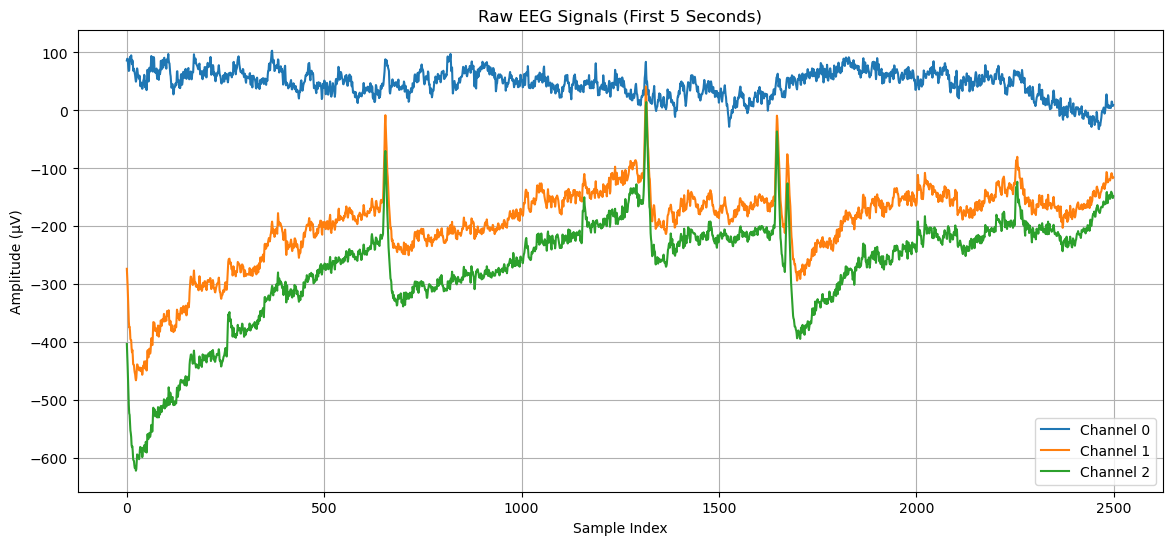

In [4]:
# Step 2: Visualize Raw EEG
fs = 500  # Sampling rate in Hz
seconds = 5
samples = fs * seconds

plt.figure(figsize=(14, 6))
for i, ch in enumerate([0, 1, 2]):
    plt.plot(df.iloc[:samples, ch], label=f'Channel {ch}')
plt.title('Raw EEG Signals (First 5 Seconds)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)
plt.show()

## Step 3: Bandpass Filtering (1–30 Hz)
**Purpose**: Remove slow drifts (<1 Hz) and high-frequency noise (>30 Hz).

**Math**: A bandpass filter is a linear system. We design it using a Butterworth filter:

$$ H(s) = \frac{1}{\sqrt{1 + (s/\omega_c)^{2n}}} $$

where $ \omega_c $ is the cutoff frequency and $ n $ is the filter order.

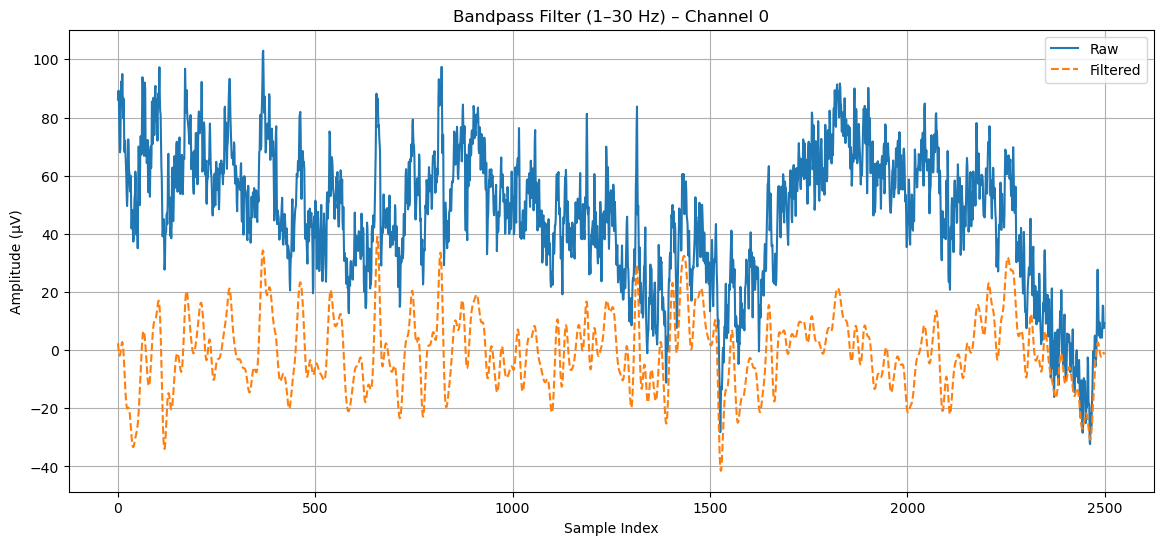

In [7]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

filtered_data = bandpass_filter(df.values, 1, 30, fs)

# Compare filtered vs raw for channel 0
plt.figure(figsize=(14, 6))
plt.plot(df.iloc[:samples, 0], label='Raw')
plt.plot(filtered_data[:samples, 0], label='Filtered', linestyle='--')
plt.title('Bandpass Filter (1–30 Hz) – Channel 0')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)
plt.show()

## Step 4: Epoch the Signal
Assume stimuli every 2 seconds. With fs = 500 Hz, that's 1000-sample intervals. We'll take 1-second (500-sample) windows.

In [10]:
epoch_len = 500
stim_interval = 1000
epochs = []

for start in range(0, len(filtered_data) - epoch_len, stim_interval):
    epoch = filtered_data[start:start + epoch_len, :]
    epochs.append(epoch)

epochs = np.array(epochs)
print(f'Total epochs: {epochs.shape[0]}, Shape: {epochs.shape}')

Total epochs: 10, Shape: (10, 500, 32)


## Step 5: Average Epochs
Averaging suppresses noise (random components) and enhances time-locked evoked potentials.

**Math Insight**:
$$ \bar{x}(t) = \frac{1}{N} \sum_{i=1}^N x_i(t) $$

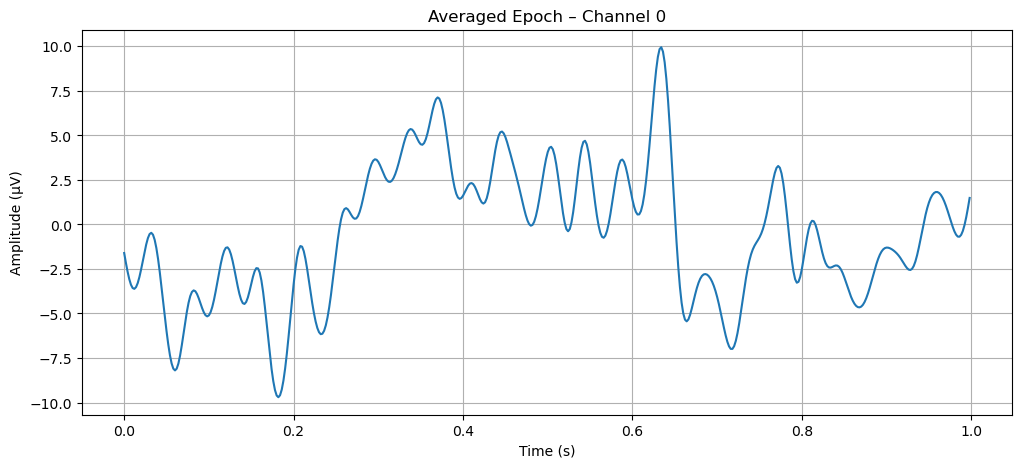

In [13]:
average_epoch = epochs[:, :, 0].mean(axis=0)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(epoch_len) / fs, average_epoch)
plt.title('Averaged Epoch – Channel 0')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.show()

## Step 6: Frequency Domain with FFT
Transform the averaged signal into the frequency domain.

**Math Insight**:
The Discrete Fourier Transform (DFT) is:
$$ X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-j2\pi kn/N} $$
which is a linear transformation.

**In matrix form**:
$$ \mathbf{X} = \mathbf{F} \cdot \mathbf{x} $$
where $ \mathbf{F} $ contains complex exponentials and acts as a change of basis.

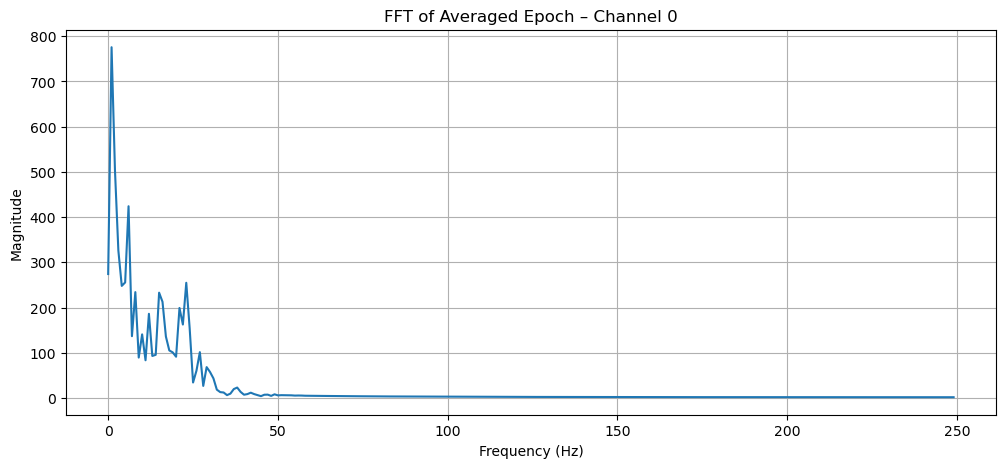

In [16]:
yf = fft(average_epoch)
xf = fftfreq(epoch_len, 1 / fs)

plt.figure(figsize=(12, 5))
plt.plot(xf[:epoch_len // 2], np.abs(yf[:epoch_len // 2]))
plt.title('FFT of Averaged Epoch – Channel 0')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()